## Engine sound analysis
### Author: Vadym Tunik

In [5]:
import os
import glob
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [6]:
FFTSIZE = 2**9
DUAL_FFTSIZE = 2**10
MAX_FREQ_BINS = 300

HOP_LENGTH_RATIO = 4
hop_length_1 = int(FFTSIZE / HOP_LENGTH_RATIO)
hop_length_2 = int(DUAL_FFTSIZE / HOP_LENGTH_RATIO)

INPUT_DATA_DIR = r"C:\Users\duina\repo\DA\engine_sound\vehicle_engine_audio_data"
OUTPUT_SIGNATURE_DIR = r"C:\Users\duina\repo\DA\engine_sound\signatures"
OUTPUT_PLOT_DIR = r"C:\Users\duina\repo\DA\engine_sound\plots"
GENERATE_PLOTS = True

In [7]:
os.makedirs(OUTPUT_SIGNATURE_DIR, exist_ok=True)
if GENERATE_PLOTS:
    os.makedirs(OUTPUT_PLOT_DIR, exist_ok=True)

audio_files = glob.glob(os.path.join(INPUT_DATA_DIR, '*.wav'))

In [8]:
for i, file_path in enumerate(audio_files):
    base_filename = os.path.splitext(os.path.basename(file_path))[0]

    y, sr = librosa.load(file_path, sr=None)
    # first STFT
    S = librosa.stft(y, n_fft=FFTSIZE, hop_length=hop_length_1)

    if S.shape[0] < MAX_FREQ_BINS:
        current_max_freq_bins = S.shape[0]
    else:
        current_max_freq_bins = MAX_FREQ_BINS
    S = S[0:current_max_freq_bins, :]

    # second STFT
    all_Sx_magnitudes = []
    max_ndiagrams = 0
    nrows_modulation = int(DUAL_FFTSIZE / 2) + 1

    for freq_bin_idx in range(S.shape[0]):
        x = np.absolute(S[freq_bin_idx, :])

        if len(x) < DUAL_FFTSIZE:
            pad_width = DUAL_FFTSIZE - len(x)
            x = np.pad(x, (0, pad_width), mode='constant')

        Sx = librosa.stft(x, n_fft=DUAL_FFTSIZE, hop_length=hop_length_2)
        Sx_mag = np.absolute(Sx)
        all_Sx_magnitudes.append(Sx_mag)

        if Sx_mag.shape[1] > max_ndiagrams:
            max_ndiagrams = Sx_mag.shape[1]

    ncols_original_freq = S.shape[0]
    Signature_power = np.zeros((ncols_original_freq, nrows_modulation, max_ndiagrams))

    for freq_bin_idx in range(ncols_original_freq):
        Sx_mag = all_Sx_magnitudes[freq_bin_idx]
        current_ndiagrams = Sx_mag.shape[1]
        Signature_power[freq_bin_idx, :, :current_ndiagrams] = Sx_mag

    output_signature_path = os.path.join(OUTPUT_SIGNATURE_DIR, f"{base_filename}_signature.npy")
    np.save(output_signature_path, Signature_power)

    if GENERATE_PLOTS:
        for d in range(max_ndiagrams):
            signature_slice = Signature_power[:, :, d]
            signature_slice_db = librosa.amplitude_to_db(np.abs(signature_slice), ref=np.max, top_db=80.0)

            plt.figure(figsize=(10, 6))
            librosa.display.specshow(signature_slice_db, sr=sr, hop_length=hop_length_1, x_axis='linear', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')

            plt.xlabel(f"Modulation Frequency (Bin Index, DUAL_FFTSIZE={DUAL_FFTSIZE})")
            plt.ylabel(f"Original Frequency (Bin Index, FFTSIZE={FFTSIZE})")

            plt.title(f'Double FFT Signature Power (Modulation Frame {d})\n{base_filename}')
            plot_filename = os.path.join(OUTPUT_PLOT_DIR, f"{base_filename}_dualfft_power-{d}.png")
            plt.savefig(plot_filename)
            plt.close()


In [16]:
signature_files = sorted(glob.glob(os.path.join(OUTPUT_SIGNATURE_DIR, '*.npy')))
X = np.array([np.load(f_path).flatten() for f_path in signature_files])
n_samples, n_features = X.shape
X[0]

array([3.47531013e+01, 5.85441933e+01, 6.26686745e+01, ...,
       1.05226953e-02, 4.09989897e-03, 9.55084246e-03])

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

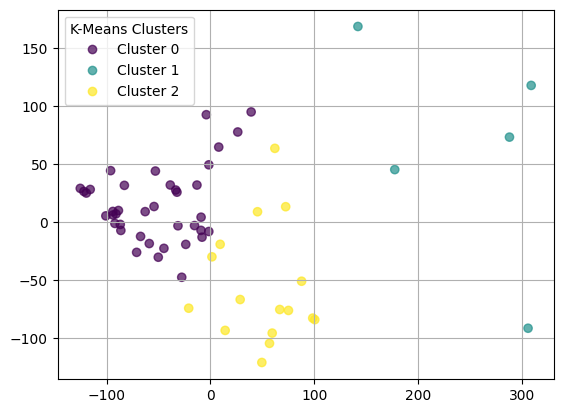

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, init="k-means++", n_init=20)
kmeans.fit(X_scaled)
kmeans_clusters = kmeans.labels_

plt.figure()
scatter_kmeans = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_clusters, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter_kmeans.legend_elements()[0], labels=[f'Cluster {i}' for i in range(3)], title="K-Means Clusters")
plt.grid(True)